In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df  = pd.read_csv('DataBase.csv')
bkp = df
df.head()

,ax,ay,az,gx,gy,gz,time
0,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512,0.002044
1,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512,0.005294
2,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457,0.018674
3,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141,0.021819
4,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035,0.035171


In [3]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


dt = 0.030
df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,az,gx,gy,gz
0,0.00,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512
1,0.03,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141
2,0.06,-0.087402,-0.084961,-1.063965,-7.873535,-3.723145,-0.427246
3,0.09,-0.089355,-0.079102,-1.066895,-2.136230,-3.479004,0.488281
4,0.12,-0.104980,-0.067383,-1.048828,-0.366211,-1.586914,-0.122070


In [4]:
xData = df.time.values
yData = df.gx.values

In [5]:
dt = 0.07

# IMPLEMENTANDO OS FILTROS

In [6]:
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter
import control as ctl

In [7]:
class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]
    

filter = LaplaceFilter(Ts=.7, UP=0.01, dt=dt)
yLaplace = np.array([filter.update(val) for val in yData])
yGaussian = gaussian_filter(yData, sigma=10)

order = 2           # Ordem do filtro
cutoff_freq = 0.05  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButter = filtfilt(b, a, yData)

In [8]:
df = pd.DataFrame({
    'laplace': yLaplace,
    'butter': yButter,
    'gaussian': yGaussian,
    'target': (yLaplace + yButter + yGaussian)/3.0,
    'data': yData,
    'time': xData
})

bkp = df.copy()
df

,laplace,butter,gaussian,target,data,time
0,-0.284517,-7.140523,-3.752310,-3.725783,-7.080078,0.00
1,-1.321364,-6.659395,-3.747578,-3.909446,-9.582520,0.03
2,-2.948214,-6.189239,-3.738312,-4.291922,-7.873535,0.06
3,-4.312619,-5.738511,-3.725025,-4.592052,-2.136230,0.09
4,-4.738286,-5.315759,-3.708307,-4.587451,-0.366211,0.12
...,...,...,...,...,...,...
273,3.586676,-1.321215,-1.125220,0.380080,-3.906250,8.19
274,1.987278,-1.283311,-1.056478,-0.117504,-2.990723,8.22
275,0.433035,-1.261627,-1.003406,-0.610666,-2.868652,8.25
276,-0.784764,-1.252801,-0.967646,-1.001737,-2.380371,8.28


# ADICIONANDO OS FILTROS

In [9]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}[n-0]'] = table[key]

    for i in range(1, n):
        table[f'{var}[n-{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}[n-0]'] + [f'{var}[n-{i}]' for i in range(1, n)]
    return table[columns]

size = 3

In [10]:
xButter = getStates(df, 'butter', 'b', size)
xButter.head()

,b[n-0],b[n-1],b[n-2]
0,-7.140523,0.000000,0.000000
1,-6.659395,-7.140523,0.000000
2,-6.189239,-6.659395,-7.140523
3,-5.738511,-6.189239,-6.659395
4,-5.315759,-5.738511,-6.189239


In [11]:
xLaplace = getStates(df, 'laplace', 'l', size)
xLaplace.head()

,l[n-0],l[n-1],l[n-2]
0,-0.284517,0.000000,0.000000
1,-1.321364,-0.284517,0.000000
2,-2.948214,-1.321364,-0.284517
3,-4.312619,-2.948214,-1.321364
4,-4.738286,-4.312619,-2.948214


In [12]:
xGaussian = getStates(df, 'gaussian', 'g', size)
xGaussian.head()

,g[n-0],g[n-1],g[n-2]
0,-3.752310,0.000000,0.000000
1,-3.747578,-3.752310,0.000000
2,-3.738312,-3.747578,-3.752310
3,-3.725025,-3.738312,-3.747578
4,-3.708307,-3.725025,-3.738312


In [13]:
df = pd.concat([df.time, xButter, xLaplace, xGaussian, df.target, df.data], axis=1)
df

,time,b[n-0],b[n-1],b[n-2],l[n-0],l[n-1],l[n-2],g[n-0],g[n-1],g[n-2],target,data
0,0.00,-7.140523,0.000000,0.000000,-0.284517,0.000000,0.000000,-3.752310,0.000000,0.000000,-3.725783,-7.080078
1,0.03,-6.659395,-7.140523,0.000000,-1.321364,-0.284517,0.000000,-3.747578,-3.752310,0.000000,-3.909446,-9.582520
2,0.06,-6.189239,-6.659395,-7.140523,-2.948214,-1.321364,-0.284517,-3.738312,-3.747578,-3.752310,-4.291922,-7.873535
3,0.09,-5.738511,-6.189239,-6.659395,-4.312619,-2.948214,-1.321364,-3.725025,-3.738312,-3.747578,-4.592052,-2.136230
4,0.12,-5.315759,-5.738511,-6.189239,-4.738286,-4.312619,-2.948214,-3.708307,-3.725025,-3.738312,-4.587451,-0.366211
...,...,...,...,...,...,...,...,...,...,...,...,...
273,8.19,-1.321215,-1.379750,-1.464167,3.586676,4.847073,5.206766,-1.125220,-1.207485,-1.300691,0.380080,-3.906250
274,8.22,-1.283311,-1.321215,-1.379750,1.987278,3.586676,4.847073,-1.056478,-1.125220,-1.207485,-0.117504,-2.990723
275,8.25,-1.261627,-1.283311,-1.321215,0.433035,1.987278,3.586676,-1.003406,-1.056478,-1.125220,-0.610666,-2.868652
276,8.28,-1.252801,-1.261627,-1.283311,-0.784764,0.433035,1.987278,-0.967646,-1.003406,-1.056478,-1.001737,-2.380371


# MODELO PREDITIVO

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

,b[n-0],b[n-1],b[n-2],l[n-0],l[n-1],l[n-2],g[n-0],g[n-1],g[n-2]
0,-7.140523,0.000000,0.000000,-0.284517,0.000000,0.000000,-3.752310,0.000000,0.000000
1,-6.659395,-7.140523,0.000000,-1.321364,-0.284517,0.000000,-3.747578,-3.752310,0.000000
2,-6.189239,-6.659395,-7.140523,-2.948214,-1.321364,-0.284517,-3.738312,-3.747578,-3.752310
3,-5.738511,-6.189239,-6.659395,-4.312619,-2.948214,-1.321364,-3.725025,-3.738312,-3.747578
4,-5.315759,-5.738511,-6.189239,-4.738286,-4.312619,-2.948214,-3.708307,-3.725025,-3.738312


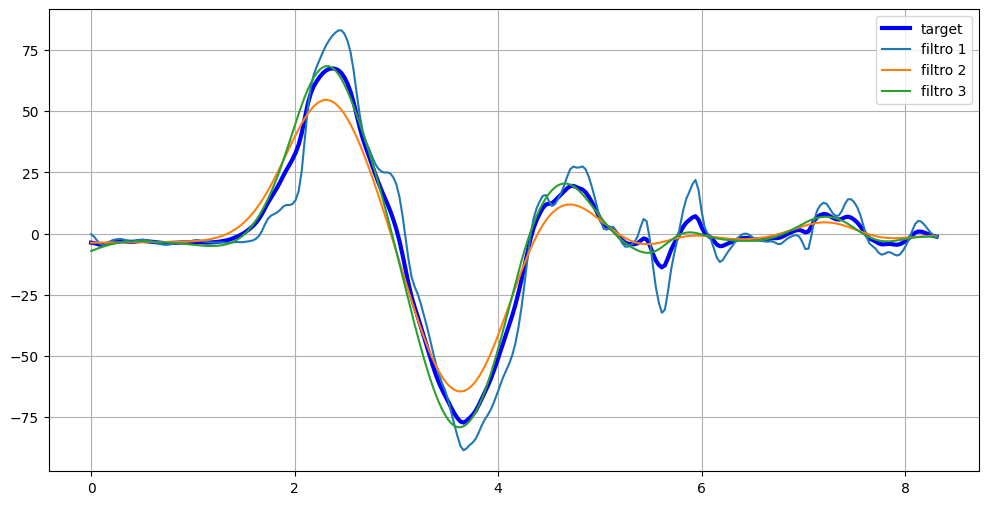

In [15]:
xData = df.drop(columns=['time', 'target', 'data'])
yData = df.target.values
display(xData.head())

plt.figure(figsize=(12, 6))
plt.plot(df.time, yData, label='target', color='blue', linewidth=3)
plt.plot(df.time, bkp.laplace, label='filtro 1')
plt.plot(df.time, bkp.gaussian, label='filtro 2')
plt.plot(df.time, bkp.butter, label='filtro 3')
plt.legend(), plt.grid()
plt.show()

### REGRESSÃO LINEAR

score: 1.000
[ 3.33333333e-01 -1.49047441e-14  6.93889390e-15  3.33333333e-01
  1.01307851e-15 -1.09634524e-15  3.33333333e-01  3.20785065e-14
 -1.55500612e-14] -1.9984014443252818e-15


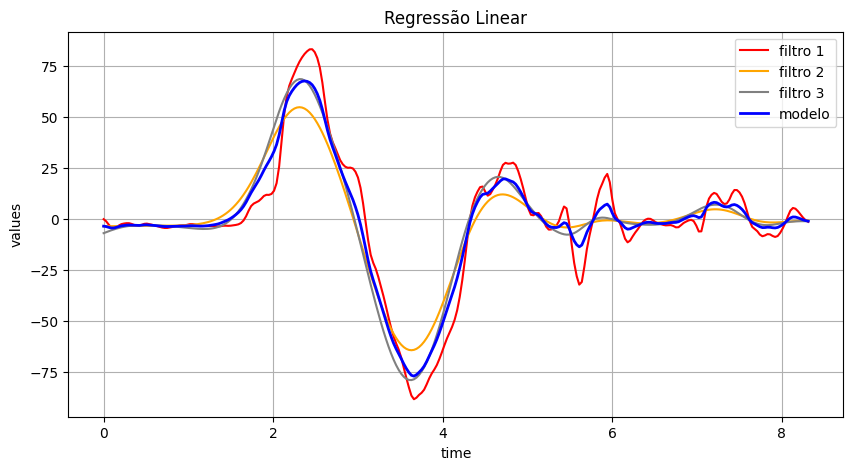

In [16]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = linearRegression(xData, yData)
print(f'score: {score:.3f}')
print(model.coef_, model.intercept_)

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, bkp.laplace, label='filtro 1', color='red')
plt.plot(df.time, bkp.gaussian, label='filtro 2', color='orange')
plt.plot(df.time, bkp.butter, label='filtro 3', color='gray')
plt.plot(df.time, yModel, label='modelo', color='blue', linewidth=2)
plt.xlabel('time'), plt.ylabel('values'), plt.legend(), plt.title('Regressão Linear')
plt.grid()

### REGRESSÃO POLINOMIAL

score: 1.000


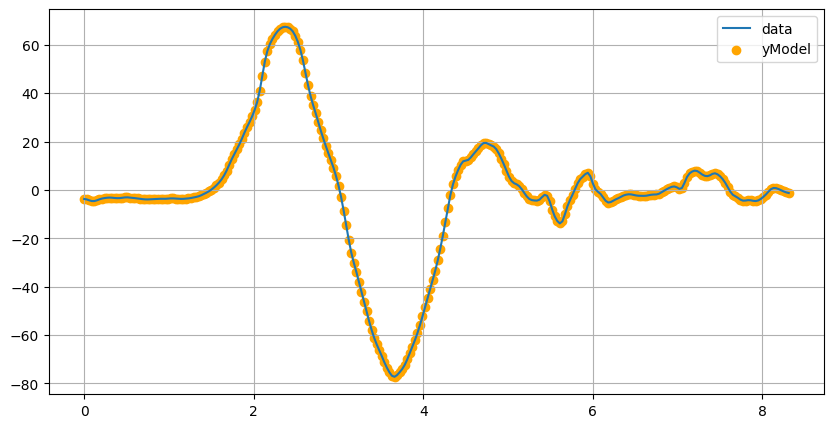

In [17]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = polinomialRegression(xData, yData, degree=2)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### ÁRVORE DE DECISÃO

score: 0.991


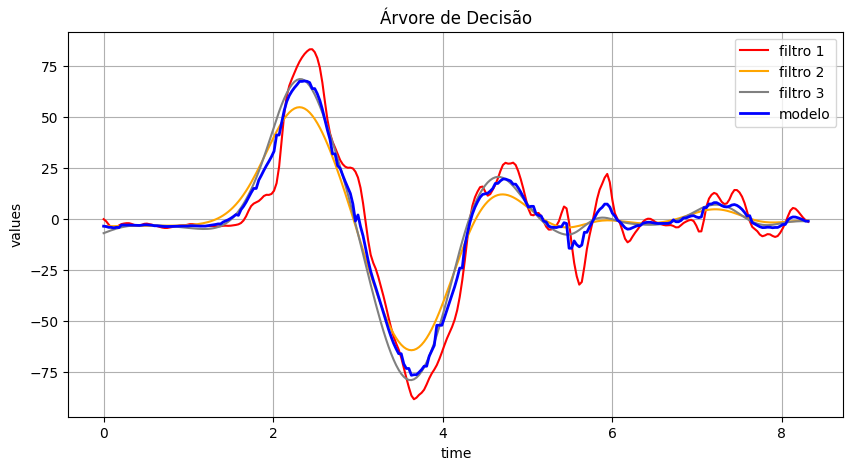

In [18]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = decisionTreeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, bkp.laplace, label='filtro 1', color='red')
plt.plot(df.time, bkp.gaussian, label='filtro 2', color='orange')
plt.plot(df.time, bkp.butter, label='filtro 3', color='gray')
plt.plot(df.time, yModel, label='modelo', color='blue', linewidth=2)
plt.xlabel('time'), plt.ylabel('values'), plt.legend(), plt.title('Árvore de Decisão')
plt.grid()

### RANDOM FOREST

score: 0.999


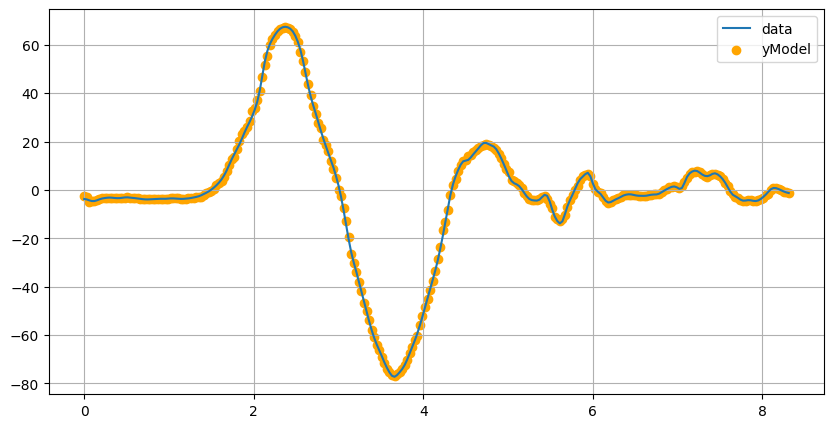

In [19]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = randomForestRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

score: 0.484


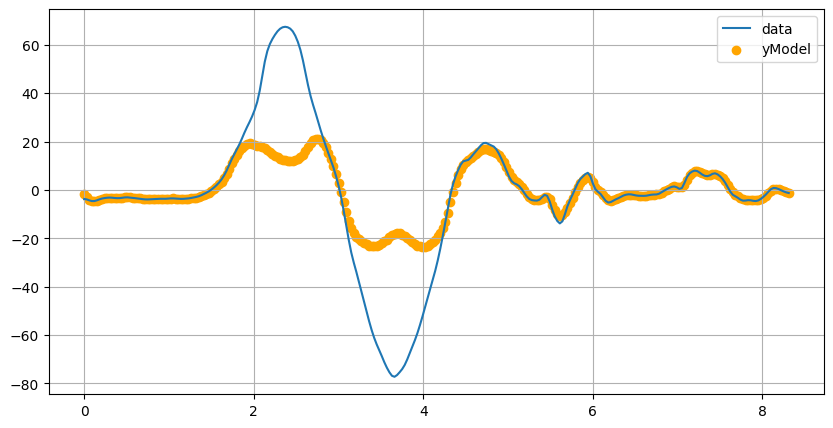

In [20]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = SVR(kernel='rbf')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = supportVectorRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### RIDGE REGRESSOR

score: 1.000


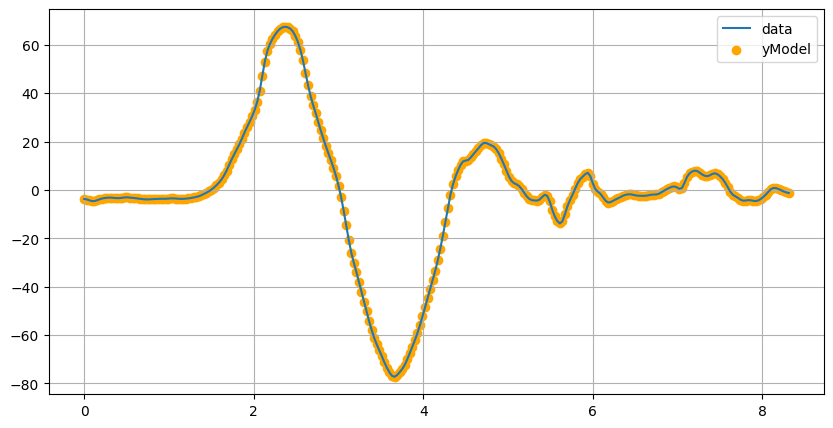

In [21]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = ridgeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### GRADIENT BOOSTER

score: 0.998


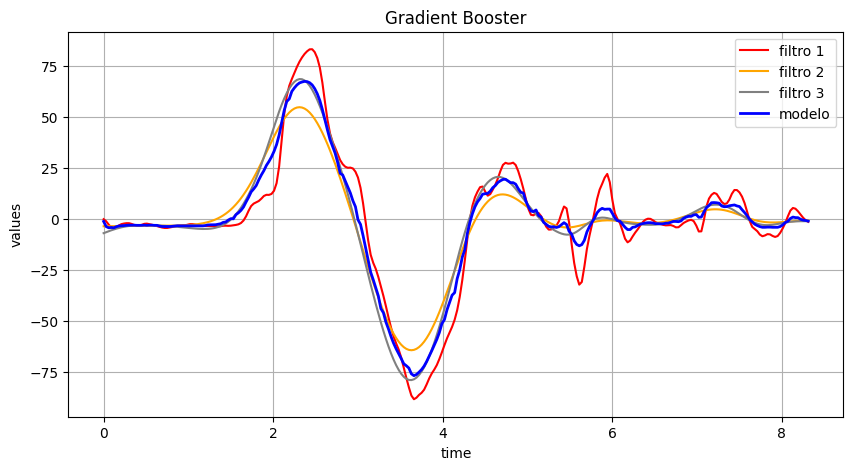

In [22]:
def gradientBoostingRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = gradientBoostingRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, bkp.laplace, label='filtro 1', color='red')
plt.plot(df.time, bkp.gaussian, label='filtro 2', color='orange')
plt.plot(df.time, bkp.butter, label='filtro 3', color='gray')
plt.plot(df.time, yModel, label='modelo', color='blue', linewidth=2)
plt.xlabel('time'), plt.ylabel('values'), plt.legend(), plt.title('Gradient Booster')
plt.grid()

### K-NEAREST NEIGHBORS

score: 0.995


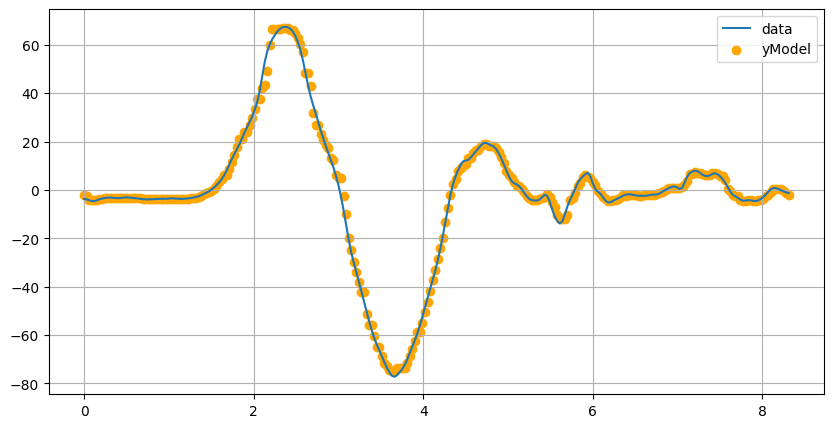

In [23]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = knnRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

# TESTANDO COM NOVOS DADOS

In [24]:
class StatesUpdater:
    states  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.states  = initial * np.ones(size)
        
    def update(self, value):
        for i in range(self.size-1, 0, -1):
            self.states[i] = self.states[i-1]

        self.states[0] = value
        return self.states
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [25]:
df = pd.read_csv('DataBase.csv')
df.head()

,ax,ay,az,gx,gy,gz,time
0,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512,0.002044
1,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512,0.005294
2,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457,0.018674
3,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141,0.021819
4,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035,0.035171


In [26]:
columns = xData.columns
columns

Index(['b[n-0]', 'b[n-1]', 'b[n-2]', 'l[n-0]', 'l[n-1]', 'l[n-2]', 'g[n-0]',
       'g[n-1]', 'g[n-2]'],
      dtype='object')

In [27]:
bstates = StatesUpdater(size)
lstates = StatesUpdater(size)
gstates = StatesUpdater(size)
yData   = []

for i, row in df.iterrows():
    butter, laplace, gaussian = row['butter'], row['laplace'], row['gaussian']
    xData  = list(bstates.update(butter)) + list(lstates.update(laplace)) + list(gstates.update(gaussian))
    xData  = pd.DataFrame([xData], columns=columns)
    yData.append(model.predict(xData)[0])


plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, label='model')
plt.plot(df.time, yData, label='raw model')
plt.legend(), plt.grid(), plt.ylim(3700, 4110)
plt.show()

KeyError: 'butter'

In [ ]:
metrics.r2_score(yData, yModel)

1.0